In [ ]:
!gdown https://drive.google.com/uc?id=1m_ecAmkgf34bgnoZrN0JjG-i6_HuPpGn

Downloading...
From (original): https://drive.google.com/uc?id=1m_ecAmkgf34bgnoZrN0JjG-i6_HuPpGn
From (redirected): https://drive.google.com/uc?id=1m_ecAmkgf34bgnoZrN0JjG-i6_HuPpGn&confirm=t&uuid=884ac7a5-0270-4c00-b239-0ad835a53ab9
To: /content/flare_2022_splitted.zip
100% 290M/290M [00:07<00:00, 36.6MB/s]


In [ ]:
!unzip /content/flare_2022_splitted.zip

Streaming output truncated to the last 5000 lines.
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_168_Aorta.png  
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_892_Aorta.png  
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_768_Aorta.png  
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_1226_Liver.png  
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_1367_Inferior_Vena_Cava.png  
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_976_Inferior_Vena_Cava.png  
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_838_Liver.png  
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_520_Liver.png  
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_235_Aorta.png  
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_196_Aorta.png  
  inflating: flare_2022_splitted/prepared_train_dataset/masks/mask_30_Liver.png  
  inflati

In [ ]:
!pip install torchmetrics
from torchmetrics.segmentation import GeneralizedDiceScore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
from torchvision import transforms
import torch
import random
import json
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from transformers import CLIPSegProcessor
import time
from torch.optim.lr_scheduler import CosineAnnealingLR
from transformers import CLIPSegProcessor
from torch.utils.tensorboard import SummaryWriter

In [ ]:
class CLIPSegTrainingDataset(Dataset):
    def __init__(self):
        self.image_dir = os.path.join("/content/flare_2022_splitted/prepared_train_dataset/images")
        self.mask_dir = os.path.join("/content/flare_2022_splitted/prepared_train_dataset/masks")

        with open(os.path.join("/content/flare_2022_splitted/prepared_train_dataset/metadata.json")) as f:
            self.metadata = json.load(f)

        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        sample = self.metadata[idx]

        img_path = os.path.join(self.image_dir, sample["image"])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        mask_path = os.path.join(self.mask_dir, sample["mask"])
        mask = Image.open(mask_path)
        mask = transforms.ToTensor()(mask)

        text_prompt = sample["text_prompt"]

        return image, text_prompt, mask

In [ ]:
class CLIPSegValidationDataset(Dataset):
    def __init__(self):
        self.image_dir = os.path.join("/content/flare_2022_splitted/prepared_val_dataset/images")
        self.mask_dir = os.path.join("/content/flare_2022_splitted/prepared_val_dataset/masks")

        with open(os.path.join("/content/flare_2022_splitted/prepared_val_dataset/metadata.json")) as f:
            self.metadata = json.load(f)

        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        sample = self.metadata[idx]

        img_path = os.path.join(self.image_dir, sample["image"])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        mask_path = os.path.join(self.mask_dir, sample["mask"])
        mask = Image.open(mask_path)
        mask = transforms.ToTensor()(mask)

        text_prompt = sample["text_prompt"]

        return image, text_prompt, mask

In [ ]:
train_dataset = CLIPSegTrainingDataset()
val_dataset = CLIPSegValidationDataset()

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
image, text_prompt, mask = train_dataset[0]

print(f"Loaded image shape: {image.shape}")
print(f"Loaded mask shape: {mask.shape}")
print(f"Text prompt: {text_prompt}")

Loaded image shape: torch.Size([3, 512, 512])
Loaded mask shape: torch.Size([1, 512, 512])
Text prompt: Liver 


In [ ]:
len(train_dataset)

5281

In [ ]:
len(val_dataset)

1379

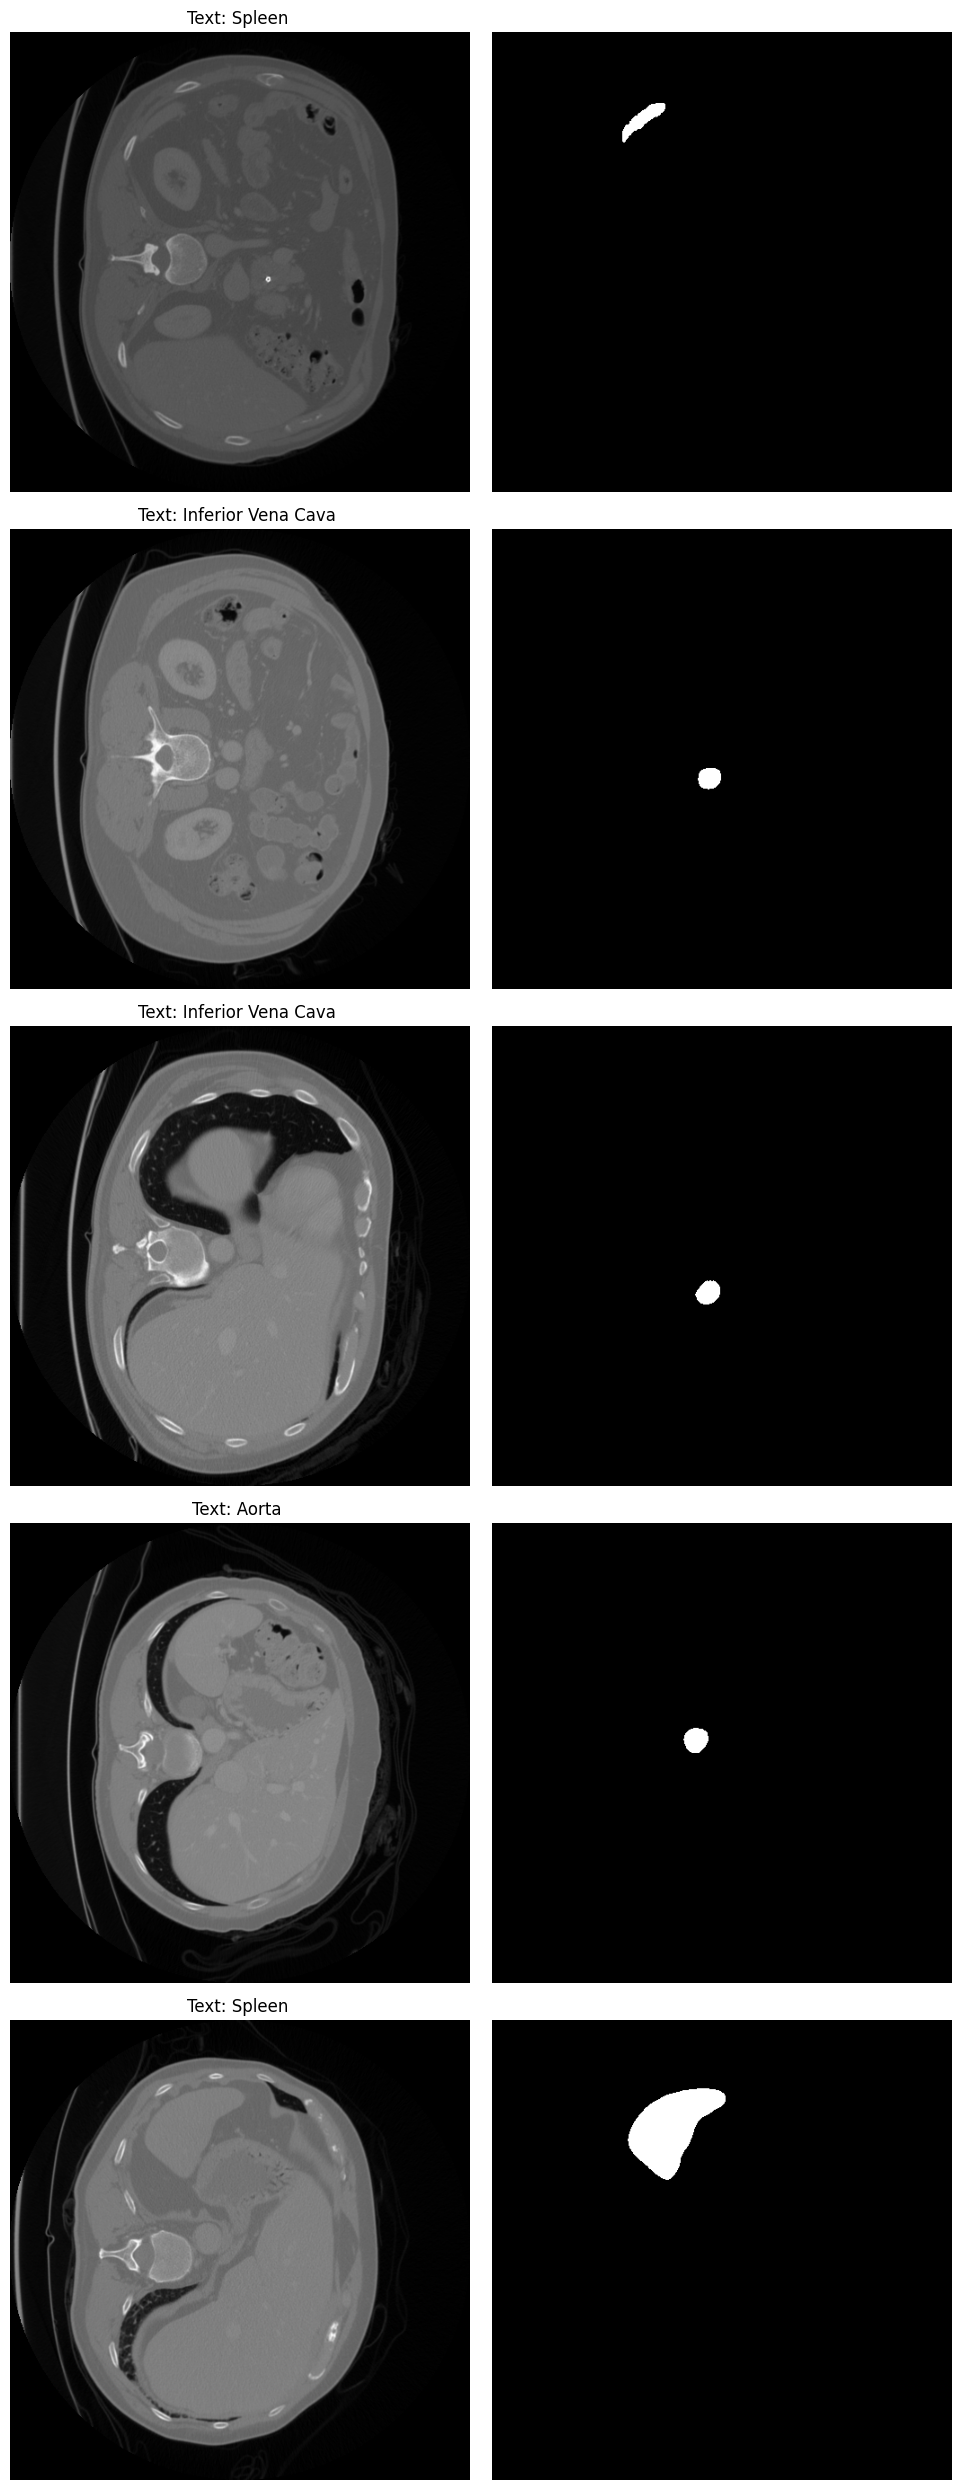

In [ ]:
def plot_batch_from_loader(batch, num_samples):

    images, texts, masks = batch
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))

    for i in range(num_samples):
        image = np.transpose(images[i], (1, 2, 0))
        mask = masks[i].squeeze()

        image = (image - image.min()) / (image.max() - image.min())

        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Text: {texts[i]}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

batch = next(iter(train_loader))
plot_batch_from_loader(batch, 5)

In [ ]:
from typing import Optional

from torch import nn
import torch
from transformers import CLIPSegForImageSegmentation


class CLIPSeg(nn.Module):
    def __init__(
        self,
        clipseg_hf_api: str,
        freeze_encoder: bool = False,
        freeze_decoder: bool = False,
    ) -> None:
        super().__init__()

        self.clipseg = CLIPSegForImageSegmentation.from_pretrained(clipseg_hf_api)

        self.clipseg.clip.requires_grad_(not freeze_encoder)
        self.clipseg.decoder.requires_grad_(not freeze_decoder)

    def forward(
        self,
        input_ids:torch.Tensor,
        pixel_values:torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        **kwargs
    ) -> torch.Tensor:

        B, C, H, W = pixel_values.shape
        outputs = self.clipseg(
            input_ids=input_ids,
            pixel_values=pixel_values,
            attention_mask=attention_mask
        )

        return outputs.logits.view(B, 1, H, W)

In [ ]:
from typing import Optional, List

from torch import nn
from transformers import CLIPSegForImageSegmentation
import torch
from transformers.modeling_attn_mask_utils import (
    _create_4d_causal_attention_mask,
    _prepare_4d_attention_mask,
)

class Adapter(nn.Module):

    def __init__(
        self, input_dim: int, adapter_dim: int, use_gelu=False
    ) -> torch.Tensor:
        super().__init__()

        self.input_dim = input_dim
        self.adapter_dim = adapter_dim

        self.fc1 = torch.nn.Linear(self.input_dim, self.adapter_dim)
        self.fc2 = torch.nn.Linear(self.adapter_dim, self.input_dim)
        if use_gelu:
            self.activation = torch.nn.GELU()
        else:
            self.activation = torch.nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        h = self.activation(self.fc1(x))
        h = self.activation(self.fc2(h))

        return x + h


class CLIPSegShallowAdapter(nn.Module):

    def __init__(
        self,
        clipseg_hf_api: str,
        adapter_dim: int,
        freeze_clipseg: bool = True,
        adapter_in_v: bool = True,
        adapter_in_l: bool = True,
        adapter_in_cond: bool = True,
    ) -> None:
        super().__init__()

        self.clipseg = CLIPSegForImageSegmentation.from_pretrained(clipseg_hf_api)
        self.clip = self.clipseg.clip

        self.adapter_dim = adapter_dim
        self.adapter_in_v = adapter_in_v
        self.adapter_in_l = adapter_in_l
        self.adapter_in_cond = adapter_in_cond
        self.clipseg_config = self.clipseg.config

        self.clipseg.requires_grad_(not freeze_clipseg)

        # The trainable params
        if self.adapter_in_v:
            self.vision_extract_adapters = nn.ModuleList(
                [
                    Adapter(
                        input_dim=self.clipseg_config.vision_config.hidden_size,
                        adapter_dim=self.adapter_dim,
                    )
                    for _ in self.clipseg.extract_layers
                ]
            )

        if self.adapter_in_l:
            self.text_extract_adapters = nn.ModuleList(
                [
                    Adapter(
                        input_dim=self.clipseg_config.text_config.hidden_size,
                        adapter_dim=self.adapter_dim,
                    )
                    for _ in self.clipseg.extract_layers
                ]
            )

        if self.adapter_in_cond:
            self.cond_adapter = Adapter(
                input_dim=self.clipseg_config.projection_dim, adapter_dim=256
            )

    def forward(
        self,
        input_ids: torch.Tensor,
        pixel_values: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        **kwargs
    ) -> torch.Tensor:

        B, C, H, W = pixel_values.shape
        # step 1: forward the query images through the frozen CLIP vision encoder
        vision_outputs = self.clip.vision_model(
            pixel_values=pixel_values,
            output_hidden_states=True,  # we need the intermediate hidden states
        )
        # pooled_output = self.clip.visual_projection(vision_outputs[1])

        vision_hidden_states, vision_pooled_output = (
            vision_outputs.hidden_states,
            vision_outputs.pooler_output,
        )

        # we add +1 here as the hidden states also include the initial embeddings

        vision_activations = []

        for i, extract_idx in enumerate(self.clipseg_config.extract_layers):
            h_state = vision_hidden_states[extract_idx + 1]
            if self.adapter_in_v:
                h_state = self.vision_extract_adapters[i](h_state)
            vision_activations.append(h_state)

        # step 2: compute conditional embeddings from text on;y
        text_outputs = self.clip.text_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
        )

        text_hidden_states, text_pooled_output = (
            text_outputs.hidden_states,
            text_outputs.pooler_output,
        )

        conditional_embeddings = self.clip.text_projection(text_pooled_output)
        if self.adapter_in_cond:
            # Apply adapter on the conditional embedding here
            conditional_embeddings = self.cond_adapter(conditional_embeddings)

        if self.adapter_in_l:
            for i, adapter in zip(
                self.clipseg.extract_layers, self.text_extract_adapters
            ):

                h_state = text_hidden_states[i + 1]

                # Extract the token sentence feature from 'eot_token', which is of the hihghest index
                h_state = h_state[
                    torch.arange(h_state.shape[0], device=h_state.device),
                    input_ids.to(dtype=torch.int, device=h_state.device).argmax(dim=-1),
                ]

                # Apply the adapter on the hidden embeddings of texts as skip connections to the condtional embeddings
                conditional_embeddings += adapter(h_state)

        # step 3: forward both the hidden_activations and fused embedding through the lightweight decoder to predict masks
        decoder_outputs = self.clipseg.decoder(
            vision_activations,
            conditional_embeddings,
        )
        logits = decoder_outputs.logits

        return logits.view(B, 1, H, W)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clipseg_hf_api = "CIDAS/clipseg-rd16"
adapter_dim = 512

model = CLIPSegShallowAdapter(
    clipseg_hf_api=clipseg_hf_api,
    adapter_dim=adapter_dim,
    freeze_clipseg=True,
    adapter_in_v=True,
    adapter_in_l=True,
    adapter_in_cond=True,
).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/600M [00:00<?, ?B/s]

In [ ]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    return total_params, trainable_params, non_trainable_params

total_params, trainable_params, non_trainable_params = count_parameters(model)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {non_trainable_params:,}")
print(f"Percentage of trainable parameters: {trainable_params/total_params*100:.2f}%")

Total parameters: 154,086,402
Trainable parameters: 4,201,984
Non-trainable parameters: 149,884,418
Percentage of trainable parameters: 2.73%


In [ ]:
processor = CLIPSegProcessor.from_pretrained(clipseg_hf_api, do_rescale=False)

learning_rate = 0.001
optimizer = AdamW(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=20)

criterion = nn.BCEWithLogitsLoss()

train_dice_metric = GeneralizedDiceScore(num_classes=2, weight_type='simple').to(device)
val_dice_metric = GeneralizedDiceScore(num_classes=2, weight_type='simple').to(device)

patience = 3
counter = 0
best_dice = 0

writer = SummaryWriter()

start_time = time.time()

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    epoch_start = time.time()

    if counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

    model.train()
    total_loss, total_dice = 0, 0

    for images, expressions, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        inputs = processor(text=expressions, images=images, return_tensors="pt", padding=True)
        input_ids, pixel_values, attention_mask = inputs['input_ids'].to(device), inputs['pixel_values'].to(device), inputs['attention_mask'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask)
        logits_resized = F.interpolate(logits, size=masks.shape[2:], mode='bilinear', align_corners=False).unsqueeze(1)
        loss = criterion(logits_resized.squeeze(1), masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds_binary = (torch.sigmoid(logits_resized) > 0.5).float().squeeze(2)
        total_dice += train_dice_metric(preds_binary, masks.long()).item()

    avg_train_loss = total_loss / len(train_loader)
    avg_train_dice = total_dice / len(train_loader)

    # Validation Loop
    model.eval()
    val_loss, val_dice = 0, 0
    with torch.no_grad():
        for images, expressions, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            inputs = processor(text=expressions, images=images, return_tensors="pt", padding=True)
            input_ids, pixel_values, attention_mask = inputs['input_ids'].to(device), inputs['pixel_values'].to(device), inputs['attention_mask'].to(device)

            logits = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask)
            logits_resized = F.interpolate(logits, size=masks.shape[2:], mode='bilinear', align_corners=False).unsqueeze(1)
            loss = criterion(logits_resized.squeeze(1), masks)
            val_loss += loss.item()
            preds_binary = (torch.sigmoid(logits_resized) > 0.5).float().squeeze(2)
            val_dice += val_dice_metric(preds_binary, masks.long()).item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_dice = val_dice / len(val_loader)

    writer.add_scalar('Loss/train', avg_train_loss, epoch)
    writer.add_scalar('Loss/val', avg_val_loss, epoch)
    writer.add_scalar('Dice/train', avg_train_dice, epoch)
    writer.add_scalar('Dice/val', avg_val_dice, epoch)

    epoch_end = time.time()
    epoch_duration = epoch_end - epoch_start
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | Train Dice: {avg_train_dice:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Dice: {avg_val_dice:.4f} | "
          f"Time: {epoch_duration:.2f} sec")

    scheduler.step()

    if avg_val_dice > best_dice:
        best_dice = avg_val_dice
        counter = 0
    else:
        counter += 1

total_time = time.time() - start_time
print(f"Total training time: {total_time:.2f} seconds")

writer.close()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/600M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


Epoch [1/20] | Train Loss: 0.0621 | Train Dice: 0.0377 | Val Loss: 0.0386 | Val Dice: 0.1389 | Time: 480.22 sec
Epoch [2/20] | Train Loss: 0.0289 | Train Dice: 0.1429 | Val Loss: 0.0271 | Val Dice: 0.1540 | Time: 477.77 sec
Epoch [3/20] | Train Loss: 0.0215 | Train Dice: 0.1836 | Val Loss: 0.0228 | Val Dice: 0.2931 | Time: 475.58 sec
Epoch [4/20] | Train Loss: 0.0175 | Train Dice: 0.3059 | Val Loss: 0.0206 | Val Dice: 0.3007 | Time: 468.72 sec
Epoch [5/20] | Train Loss: 0.0168 | Train Dice: 0.3206 | Val Loss: 0.0200 | Val Dice: 0.3049 | Time: 470.41 sec
Epoch [6/20] | Train Loss: 0.0150 | Train Dice: 0.3550 | Val Loss: 0.0189 | Val Dice: 0.3440 | Time: 466.34 sec
Epoch [7/20] | Train Loss: 0.0142 | Train Dice: 0.3914 | Val Loss: 0.0178 | Val Dice: 0.3540 | Time: 469.39 sec
Epoch [8/20] | Train Loss: 0.0135 | Train Dice: 0.4542 | Val Loss: 0.0184 | Val Dice: 0.3794 | Time: 471.27 sec
Epoch [9/20] | Train Loss: 0.0130 | Train Dice: 0.5198 | Val Loss: 0.0171 | Val Dice: 0.4434 | Time: 473

Total Training Time = 2 hours 13 minutes

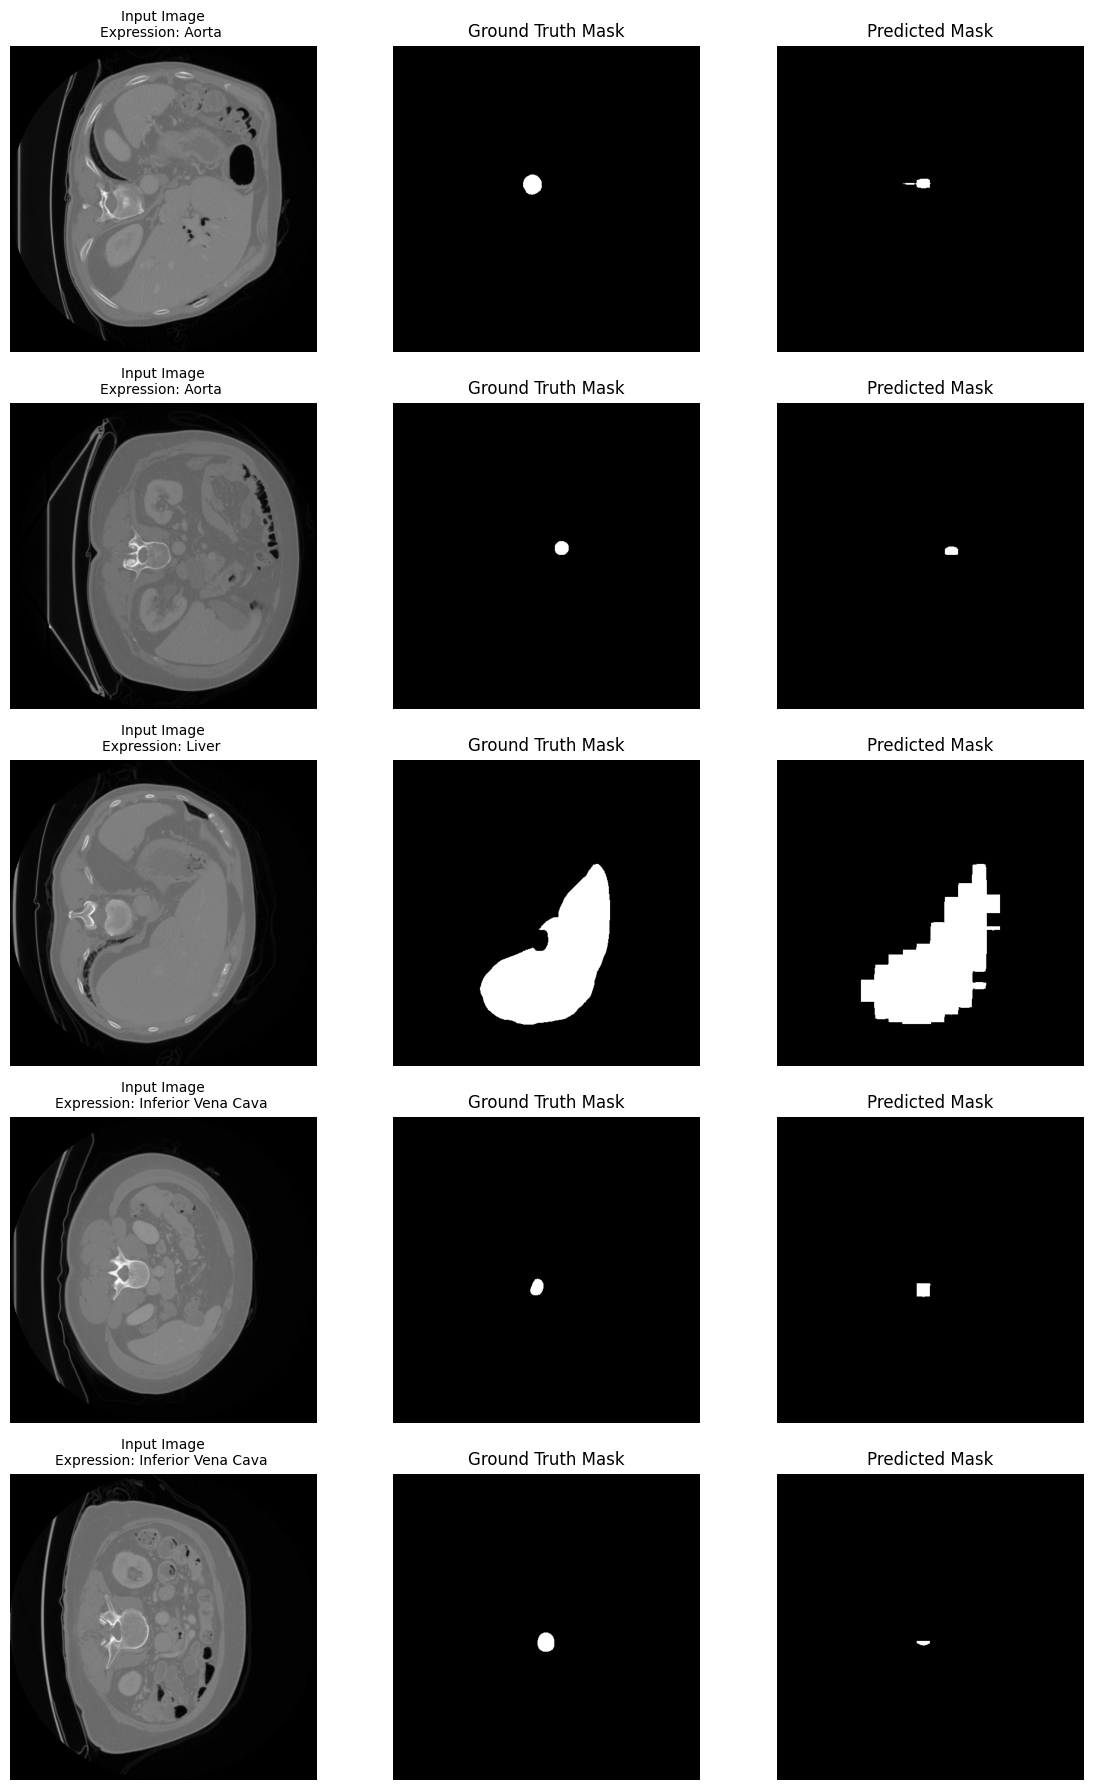

In [ ]:
model.eval()

images_batch, expressions_batch, masks_batch = next(iter(train_loader))

random_indices = random.sample(range(len(images_batch)), 5)

images = images_batch[random_indices].to(device)
masks = masks_batch[random_indices].to(device)
expressions = [expressions_batch[i] for i in random_indices]

inputs = processor(text=expressions, images=images, return_tensors="pt", padding=True)
input_ids = inputs['input_ids'].to(device)
pixel_values = inputs['pixel_values'].to(device)
attention_mask = inputs['attention_mask'].to(device)

with torch.no_grad():
    logits = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask)

logits_resized = F.interpolate(logits, size=masks.shape[2:], mode='bilinear', align_corners=False)
pred_masks = (torch.sigmoid(logits_resized) > 0.5).float()

images = images.cpu().numpy().transpose(0, 2, 3, 1)
masks = masks.cpu().numpy()
pred_masks = pred_masks.cpu().numpy()

fig, axes = plt.subplots(5, 3, figsize=(12, 18))

for i in range(5):
    axes[i, 0].imshow(images[i])
    axes[i, 0].set_title(f"Input Image\nExpression: {expressions[i]}", fontsize=10)
    axes[i, 0].axis("off")

    axes[i, 1].imshow(masks[i].squeeze(), cmap="gray")
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(pred_masks[i].squeeze(), cmap="gray")
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


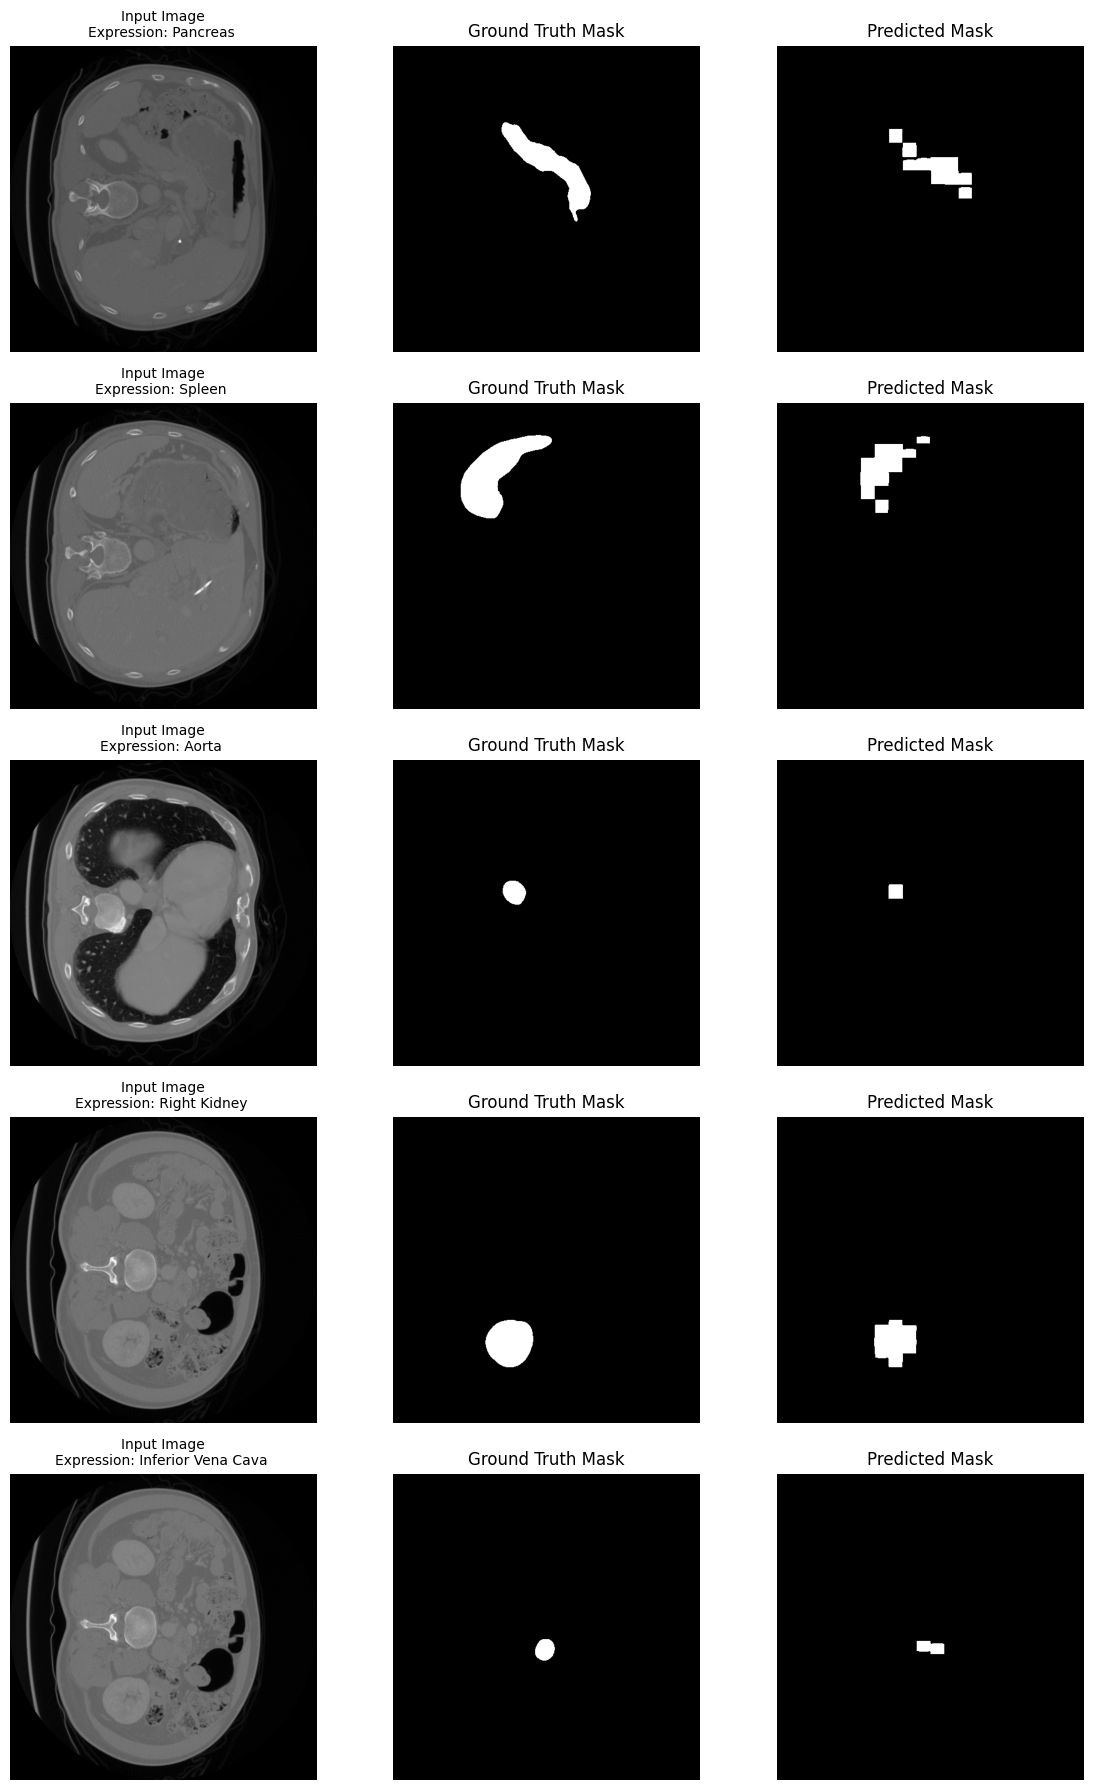

In [ ]:
model.eval()

images_batch, expressions_batch, masks_batch = next(iter(val_loader))

random_indices = random.sample(range(len(images_batch)), 5)

images = images_batch[random_indices].to(device)
masks = masks_batch[random_indices].to(device)
expressions = [expressions_batch[i] for i in random_indices]

inputs = processor(text=expressions, images=images, return_tensors="pt", padding=True)
input_ids = inputs['input_ids'].to(device)
pixel_values = inputs['pixel_values'].to(device)
attention_mask = inputs['attention_mask'].to(device)

with torch.no_grad():
    logits = model(input_ids=input_ids, pixel_values=pixel_values, attention_mask=attention_mask)

logits_resized = F.interpolate(logits, size=masks.shape[2:], mode='bilinear', align_corners=False)
pred_masks = (torch.sigmoid(logits_resized) > 0.5).float()

images = images.cpu().numpy().transpose(0, 2, 3, 1)
masks = masks.cpu().numpy()
pred_masks = pred_masks.cpu().numpy()

fig, axes = plt.subplots(5, 3, figsize=(12, 18))

for i in range(5):
    axes[i, 0].imshow(images[i])
    axes[i, 0].set_title(f"Input Image\nExpression: {expressions[i]}", fontsize=10)
    axes[i, 0].axis("off")

    axes[i, 1].imshow(masks[i].squeeze(), cmap="gray")
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(pred_masks[i].squeeze(), cmap="gray")
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()